# TASK 2 - Description

What is the largest 1D array that you can simulate for the full Rydberg Hamiltonian, with exact time evolution as above? What implications does this have for quantum advantage, particularly in light of the experiments mentioned above?

Next, in order to significantly reduce the size of the state space required to solve Rydberg problems, one can eliminate states that violate the blockade constraint (e.g. more than one atom being excited within ). Implement the blockade approximation and justify it; i.e. when do you expect it to be valid? You can find more detailed explaination about this approximation in Rydberg Blockade section.

Repeat your study of 1D arrays, and find the largest system for which you can adiabatically prepare the 
 state. What is the largest 2D array for which you can adiabatically prepare the checkerboard phase? Has quantum advantage for 2D arrays already been achieved?

# 1D array gap scaling analysis is in TASK 1 notebook

Here we check Bloackade approximation for 1D and further focus on 2D

In [45]:
# Imports 

using Bloqade
using PythonCall
using KrylovKit
using SparseArrays

plt = pyimport("matplotlib.pyplot");

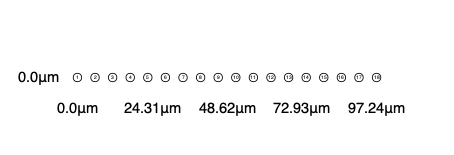

In [13]:
nsites = 18
r_b = 5.72
atoms = generate_sites(ChainLattice(), nsites, scale = r_b)

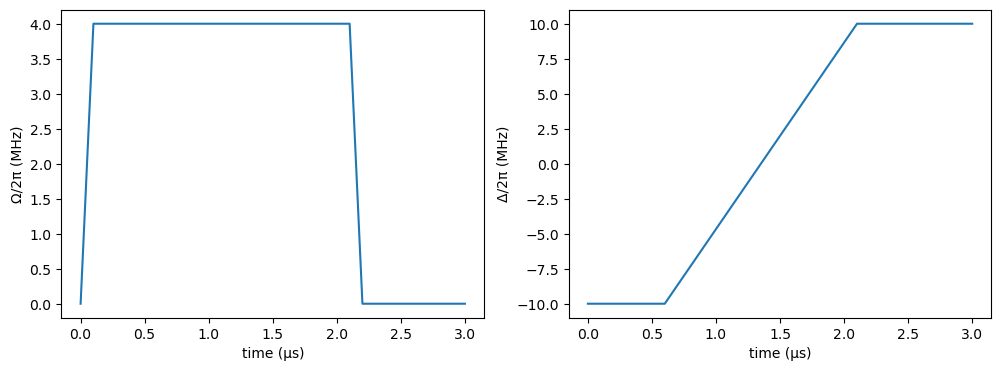

In [14]:
total_time = 3.0;
Omega_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Omega_max, Omega_max, 0, 0]);

U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

# parameters tuning protocol plot

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [15]:
# Register for subspaces
subspace = blockade_subspace(atoms, r_b)
reg = zero_state(subspace)



SubspaceArrayReg{2, ComplexF64, Vector{ComplexF64}, Subspace{Vector{Int64}}}(18, ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], Subspace{Vector{Int64}}(18, Dict(141394 => 8238, 174088 => 10831, 1090 => 228, 152097 => 9067, 70729 => 4957, 70673 => 4937, 136450 => 7628, 65856 => 4301, 33025 => 2702, 136297 => 7597…), [0, 1, 2, 4, 5, 8, 9, 10, 12, 13  …  174752, 174753, 174754, 174756, 174757, 174760, 174761, 174762, 174764, 174765]))

In [16]:
# Hamiltonian and time-dependent dynamics
h = rydberg_h(atoms; Δ, Ω)
prob = SchrodingerProblem(reg, total_time, h)
integrator = init(prob, Vern8())

#prob = SchrodingerProblem(reg, total_time, h)
#emulate!(prob)
#bitstring_hist(prob.reg; nlargest = 20)

# Timesteps
densities = []
for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
    push!(densities, rydberg_density(reg))
end
D = hcat(densities...)



18×3001 Matrix{Float64}:
 0.0  5.7785e-9  7.2223e-6   7.2223e-6   …  0.997055   0.997055   0.997055
 0.0  5.7785e-9  7.22228e-6  7.22228e-6     0.0103437  0.0103437  0.0103437
 0.0  5.7785e-9  7.2223e-6   7.2223e-6      0.863527   0.863527   0.863527
 0.0  5.7785e-9  7.2223e-6   7.2223e-6      0.143383   0.143383   0.143383
 0.0  5.7785e-9  7.22228e-6  7.22228e-6     0.679344   0.679344   0.679344
 0.0  5.7785e-9  7.2223e-6   7.2223e-6   …  0.318932   0.318932   0.318932
 0.0  5.7785e-9  7.2223e-6   7.2223e-6      0.567433   0.567433   0.567433
 0.0  5.7785e-9  7.22228e-6  7.22228e-6     0.41222    0.41222    0.41222
 0.0  5.7785e-9  7.22228e-6  7.22228e-6     0.441979   0.441979   0.441979
 0.0  5.7785e-9  7.22228e-6  7.22228e-6     0.537234   0.537234   0.537234
 0.0  5.7785e-9  7.22228e-6  7.22228e-6  …  0.31021    0.31021    0.31021
 0.0  5.7785e-9  7.2223e-6   7.2223e-6      0.669064   0.669064   0.669064
 0.0  5.7785e-9  7.2223e-6   7.2223e-6      0.203257   0.203257   0.203257
 

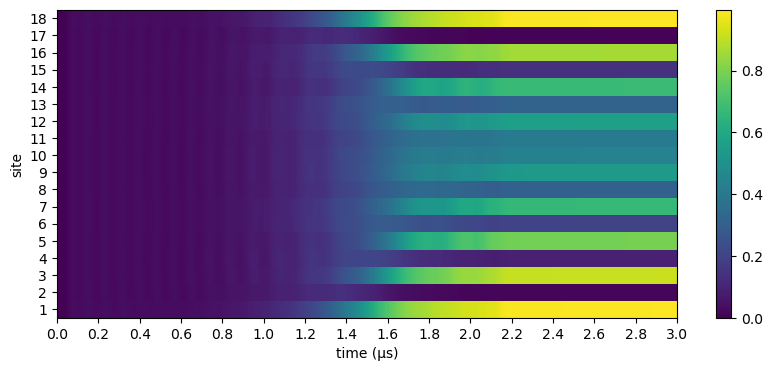

In [17]:
# Plotting Rydberg density for each site
fig, ax = plt.subplots(figsize = (10, 4))
shw = ax.imshow(real(D), interpolation = "nearest", aspect = "auto", extent = [0, total_time, 0.5, nsites + 0.5])
ax.set_xlabel("time (μs)")
ax.set_ylabel("site")
ax.set_xticks(0:0.2:total_time)
ax.set_yticks(1:nsites)
bar = fig.colorbar(shw)
fig

# 2D Lattice example : checkerboard state preparation

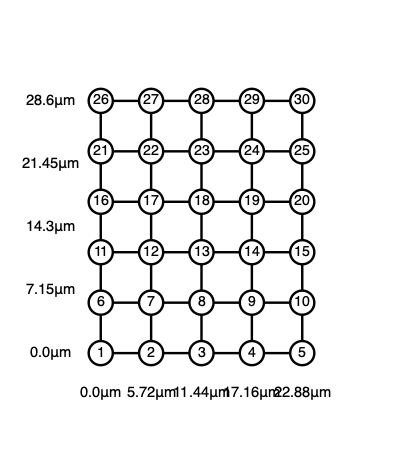

In [46]:
nx, ny = 5, 6
nsites = nx * ny
r_b = 5.72
atoms = generate_sites(SquareLattice(), nx, ny, scale = r_b)
Bloqade.plot(atoms, blockade_radius = r_b + 0.05)

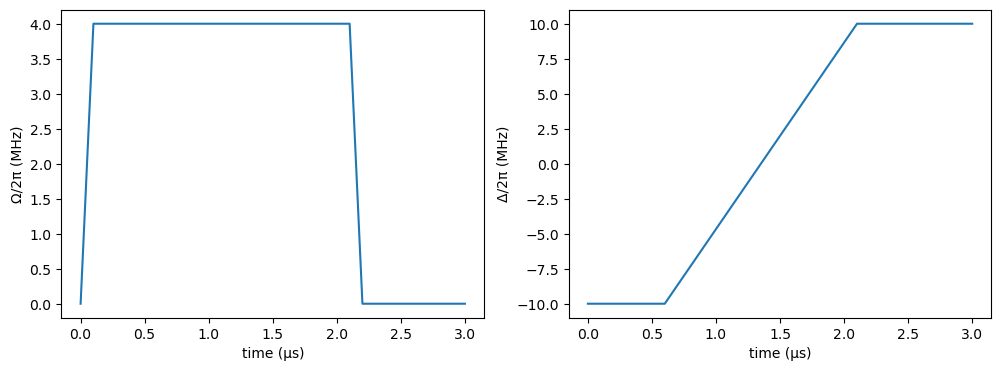

In [47]:
total_time = 3.0;
Omega_max = 2π * 4;
Ω = piecewise_linear(clocks = [0.0, 0.1, 2.1, 2.2, total_time], values = [0.0, Omega_max, Omega_max, 0, 0]);

U1 = -2π * 10;
U2 = 2π * 10;
Δ = piecewise_linear(clocks = [0.0, 0.6, 2.1, total_time], values = [U1, U1, U2, U2]);

# parameters tuning protocol plot

fig, (ax1, ax2) = plt.subplots(ncols = 2, figsize = (12, 4))
Bloqade.plot!(ax1, Ω)
ax1.set_ylabel("Ω/2π (MHz)")
Bloqade.plot!(ax2, Δ)
ax2.set_ylabel("Δ/2π (MHz)")
fig

In [48]:
# Register for subspaces
subspace = blockade_subspace(atoms, r_b + 0.05)
reg = zero_state(subspace)




SubspaceArrayReg{2, ComplexF64, Vector{ComplexF64}, Subspace{Vector{Int64}}}(30, ComplexF64[1.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im  …  0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im, 0.0 + 0.0im], Subspace{Vector{Int64}}(30, Dict(270550161 => 217987, 541100322 => 328832, 8922185 => 28651, 84164865 => 125405, 17844370 => 43217, 673464592 => 418155, 704974932 => 437543, 21303621 => 52530, 356516018 => 305129, 273941002 => 229009…), [0, 1, 2, 4, 5, 8, 9, 10, 16, 17  …  715827840, 715827841, 715827842, 715827848, 715827849, 715827850, 715827872, 715827874, 715827880, 715827882]))

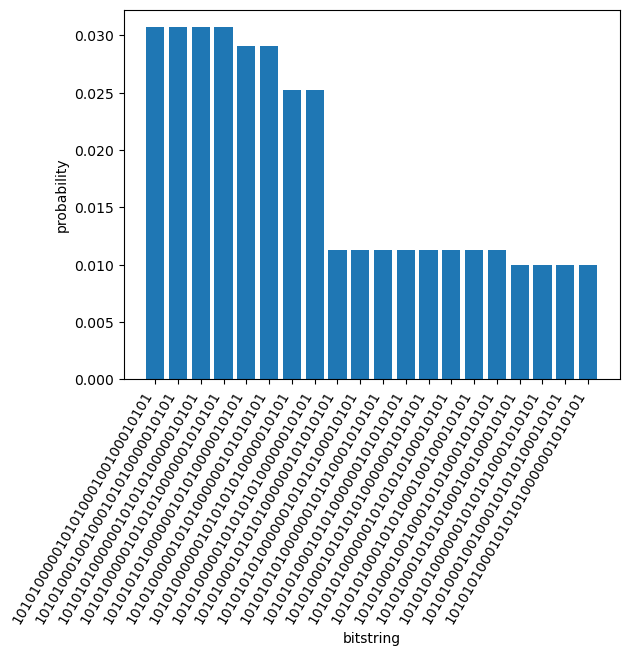

In [49]:
# Hamiltonian and time-dependent dynamics
h = rydberg_h(atoms; Δ, Ω)
#prob = SchrodingerProblem(reg, total_time, h)
#integrator = init(prob, Vern8())

prob = SchrodingerProblem(reg, total_time, h)
emulate!(prob)
bitstring_hist(prob.reg; nlargest = 20)

# Timesteps
#densities = []
#for _ in TimeChoiceIterator(integrator, 0.0:1e-3:total_time)
#    push!(densities, rydberg_density(reg))
#end
#D = hcat(densities...)




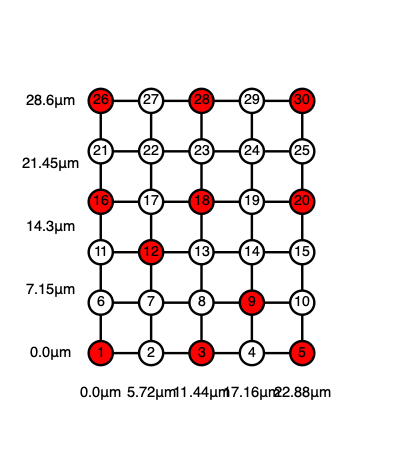

In [50]:
best_bit_strings = most_probable(prob.reg, 15)
Bloqade.plot(atoms, blockade_radius = r_b+0.05;
    colors = [iszero(b) ? "white" : "red" for b in best_bit_strings[1]])